# Gamma Regression

We consider a dataset that has miles-per-gallon for caes based on horse-power, acceleration, and car origin (we take an excerpt from the [UCI dataset mpg](https://archive.ics.uci.edu/dataset/9/auto+mpg]) that has various other features). Our objective is to predict current mpg. You can imagine a use-case as checking reported mpg figures by producers and whether a care is efficient relative to its characteristics.

We will first use OLS linear regression, illustrate potential issues, and then showcase Gamma regression as an alternative.

Let's start by loading the libraries that are going to be helpful. We're again going to rely on the package [statsmodels](https://www.statsmodels.org/stable/index.html) and the statistical learning toolkit [ski-cit learn](https://scikit-learn.org/stable/index.html), which provide GLM functionalty.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import GammaRegressor

### Load Data

In [2]:
!git clone https://github.com/danielbauer1979/MSDIA_PredictiveModelingAndMachineLearning.git

fatal: destination path 'MSDIA_PredictiveModelingAndMachineLearning' already exists and is not an empty directory.


In [3]:
dat_mpg = pd.read_csv('MSDIA_PredictiveModelingAndMachineLearning/GB886_III_7_auto-mpg.csv')
dat_mpg.head()

,mpg,horsepower,acceleration,origin
0,13.0,175,11.0,A
1,15.0,190,8.5,A
2,17.0,150,11.5,A
3,19.4,90,17.2,A
4,24.3,90,20.1,A


In [4]:
dat_mpg.describe()

,mpg,horsepower,acceleration
count,392.000000,392.000000,392.000000
mean,23.445918,104.469388,15.541327
std,7.805007,38.491160,2.758864
min,9.000000,46.000000,8.000000
25%,17.000000,75.000000,13.775000
50%,22.750000,93.500000,15.500000
75%,29.000000,126.000000,17.025000
max,46.600000,230.000000,24.800000


Data explanation:
* mpg - miles per gallon
* horsepower - Engine horsepower
* acceleration - Time to accelerate from 0 to 60 mph (sec.)
* origin - Origin of car (A. American, B. European, C. Japanese)

## Run an OLS Regression and Analyze

Typically, we would do some data exploration. However, instead we are going to run a OLS linear regression as a baseline. We will then check model validity, and plot some relationships that may be tricky. This is to showcase that running a model "blind" can be problematic.

In [5]:
y = dat_mpg['mpg']
X = dat_mpg.drop(columns=['mpg','origin'])
X = pd.concat([X,pd.get_dummies(dat_mpg['origin'], drop_first=True)], axis =1)
X = sm.add_constant(X) # Add a constant term as the default model doesn't include one
model_ols = sm.OLS(y, X.astype(float)).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     202.4
Date:                Thu, 09 Oct 2025   Prob (F-statistic):           1.80e-93
Time:                        20:07:37   Log-Likelihood:                -1139.9
No. Observations:                 392   AIC:                             2290.
Df Residuals:                     387   BIC:                             2310.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           46.0946      2.581     17.859      0.000      41.020      51.169
horsepower      -0.1589      0.009    -17.545      0.000      -0.177      -0.141
acceleration    -0.4763      0.114     -4.165      0.000      -0.701      -0.251
B                2.3112      0.665      3.478      0.001       1.005       3.618
C                4.7476      0.643      7.385      0.000       3.484       6.012
==============================================================================
Omnibus:                       33.459   Durbin-Watson:                   1.441
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.581
Skew:                           0.700   Prob(JB):                     1.54e-09
Kurtosis:                       3.723   Cond. No.                     1.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

So, we see that some of the "fit metrics" are indicating a poor firt. The skew is positive (i.e., the distibution seems skewed) and the kurtosis is larger than three. Furthermore, the Jaque-Bera test seeems to reject a normal assumption (although the sample size is somewhat small for the JB test).

Let's look at the residual plots for model validation:

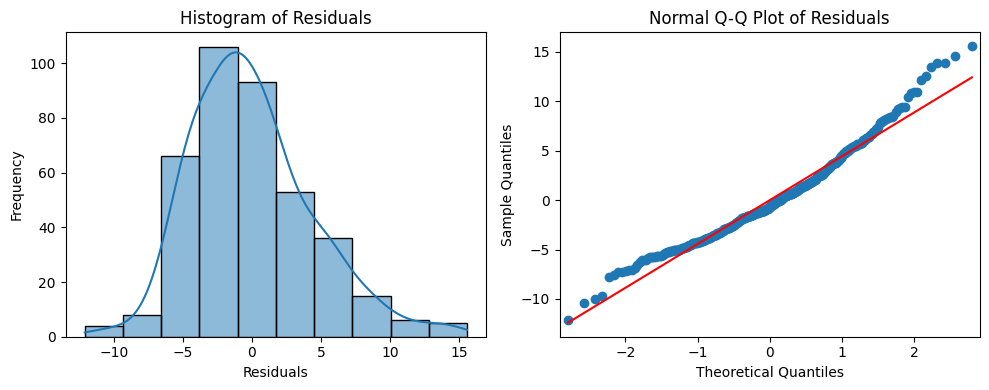

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(model_ols.resid, bins=10, ax=axes[0], kde=True)
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Residuals')
sm.qqplot(model_ols.resid, line='s', ax=axes[1])
axes[1].set_title('Normal Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

We notice the skewness and the tails of the distributions do not seem to be approproately captured by the normal distribution.

Let's also plot the errors as a function of the feature variables horsepower and acceleration--recall that the assumption of OLS linear regression is an iid. error distribution with a constant variance:

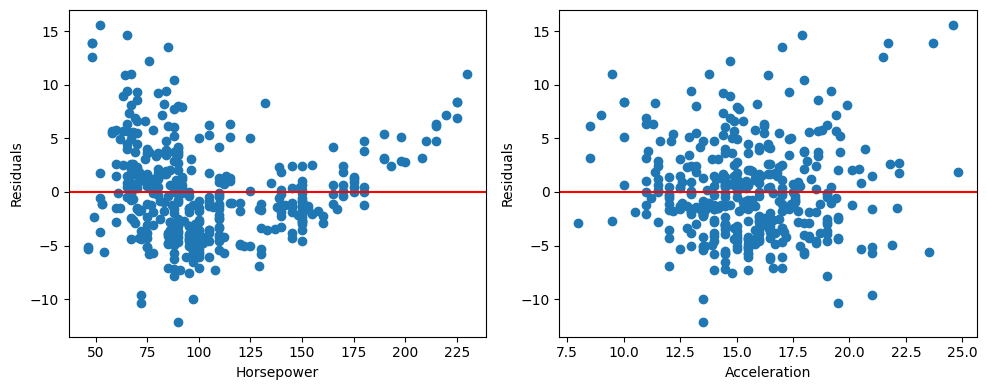

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(dat_mpg['horsepower'], model_ols.resid)
axes[0].set_xlabel('Horsepower')
axes[0].set_ylabel('Residuals')
axes[0].axhline(0, color='red')

axes[1].scatter(dat_mpg['acceleration'], model_ols.resid)
axes[1].set_xlabel('Acceleration')
axes[1].set_ylabel('Residuals')
axes[1].axhline(0, color='red')

plt.tight_layout()
plt.show()

We notice that the assumption of a constant variance around the zero does not seem like an appropriate assumption.

Let's also plot the target variable as a function of the features horsepower and acceleration -- recall that the OLS linear regression assumption is that $y$ depends linearly on $x_k$:

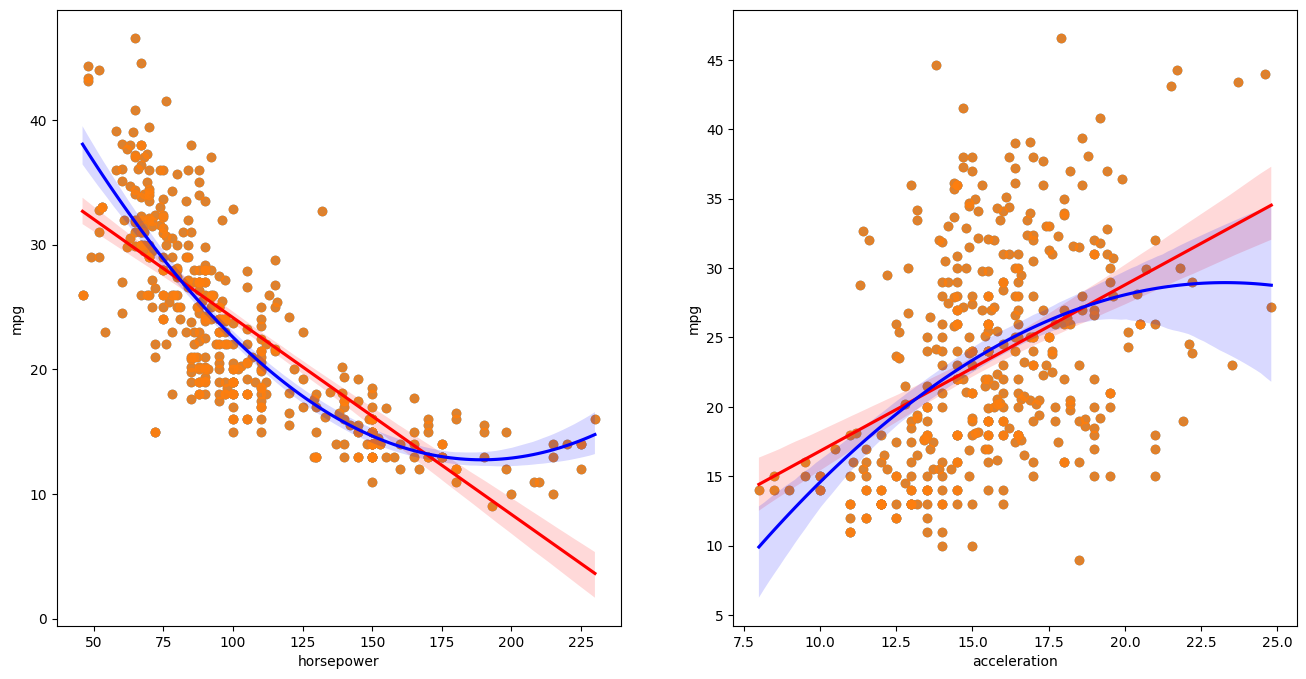

In [8]:
# Plot mpg vs horsepower with linear trendline
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.regplot(x=dat_mpg['horsepower'], y=dat_mpg['mpg'], line_kws={'color': 'red'})
# Add exponential trendline
sns.regplot(x=dat_mpg['horsepower'], y=dat_mpg['mpg'], order=2, line_kws={'color': 'blue'})

# Plot mpg vs acceleration with linear trendline
plt.subplot(1, 2, 2)
sns.regplot(x=dat_mpg['acceleration'], y=dat_mpg['mpg'], line_kws={'color': 'red'})
# Add exponential trendline
sns.regplot(x=dat_mpg['acceleration'], y=dat_mpg['mpg'], order=2, line_kws={'color': 'blue'})

plt.show()

So we see that the data are not well matched by the red linear regression line, further indicating potential issues with the OLS linear regression assumption.

Finally, let's compare the outcomes with the predictions:

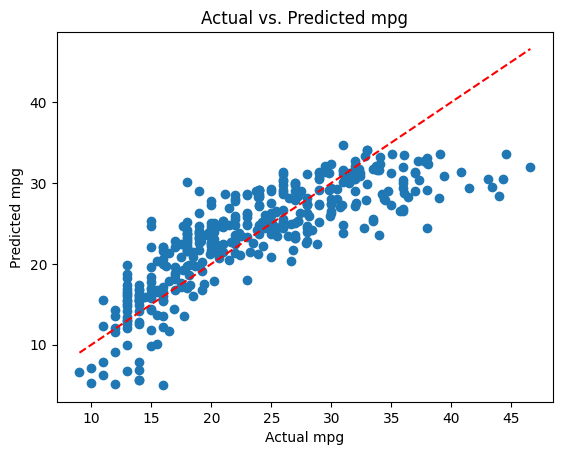

In [9]:
plt.scatter(dat_mpg['mpg'], model_ols.predict())
plt.plot([min(dat_mpg['mpg']), max(dat_mpg['mpg'])], [min(dat_mpg['mpg']), max(dat_mpg['mpg'])], 'r--')
plt.xlabel('Actual mpg')
plt.ylabel('Predicted mpg')
plt.title('Actual vs. Predicted mpg')
plt.show()

So it doesn't look very satisfactory overall...

## Gamma Regression

So let's try a Gamma regression with a log-link function.

### Why and what does that mean?

Formally, a Gamma regression with log-link assumes:

$$
y_i | x_i ~ Gamma(\mu_i | \varphi), \text{ where } \log\{\mu_i\} = \beta_0 + \beta_1\,x_{i1}+\ldots+\beta_p\,x_{ip} = x_i \, \beta
$$

Note that this means for the expected value and the variance of a random sample $Y_i$ with features $x_i$

\begin{eqnarray*}
E[Y_i | x_i] &=& \mu_i = e^{ \beta_0 + \beta_1\,x_{i1}+\ldots+\beta_p\,x_{ip}} = e^{x_i \, \beta}\\
Var[Y_i | x_i ] &=& \mu_i^2 \, \varphi.
\end{eqnarray*}

Hence, the assumptions differ from OLS linear regression in several ways:

* We assume $Y$ is Gamma distributed. The Gamma distribution is positive, skewed, and has heavier tails than the Normal distribution.
* We assume that $Y$ depends on $x$ in an exponential fashion, as the equation for the expected value makes clear. We included an exponential trend

So let's run the Gamma regression using the statsmodel GLM routines (note that we need to defined the log function, because the standard link function for Gamma regression is different):

In [10]:
link_g = sm.genmod.families.links.log
model_gamma = sm.GLM(y, X.astype(float), family=sm.families.Gamma(link_g())).fit()
model_gamma.summary()

C:\Users\brown\AppData\Roaming\Python\Python313\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mpg   No. Observations:                  392
Model:                            GLM   Df Residuals:                      387
Model Family:                   Gamma   Df Model:                            4
Link Function:                    log   Scale:                        0.030745
Method:                          IRLS   Log-Likelihood:                -1078.8
Date:                Thu, 09 Oct 2025   Deviance:                       11.406
Time:                        20:23:15   Pearson chi2:                     11.9
No. Iterations:                    11   Pseudo R-squ. (CS):             0.9342
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.2278      0.101     41.679      0.000       4.029       4.427
horsepower      -0.0076      0.000    -21.482      0.000      -0.008      -0.007
acceleration    -0.0235      0.004     -5.237      0.000      -0.032      -0.015
B                0.0893      0.026      3.420      0.001       0.038       0.141
C                0.1706      0.025      6.754      0.000       0.121       0.220
================================================================================
"""

### So, is it better?

The short answer is yes. The pseudo-R-squared (determined as the correlation of predictions and observations, squared, as we discussed before) with 93% is substantively higher than the OLS R-squared of 68%. The Pearson chi2 goodness of fit metric with 11.9 isn't gigantic (though it's also not very small, which would indicated a very good fit).

Let's compare predictions and outcomes here:

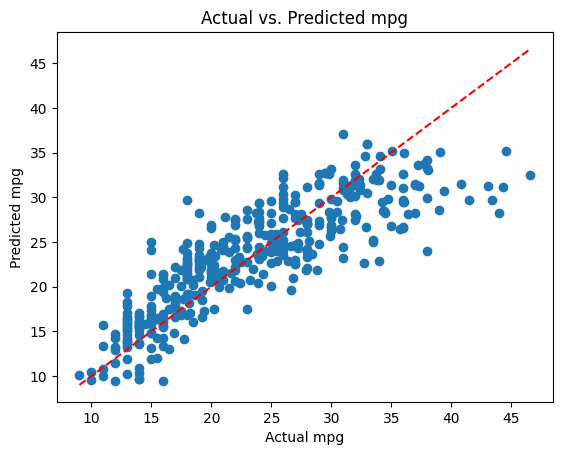

In [11]:
plt.scatter(dat_mpg['mpg'], model_gamma.predict())
plt.plot([min(dat_mpg['mpg']), max(dat_mpg['mpg'])], [min(dat_mpg['mpg']), max(dat_mpg['mpg'])], 'r--')
plt.xlabel('Actual mpg')
plt.ylabel('Predicted mpg')
plt.title('Actual vs. Predicted mpg')
plt.show()

So the fit seems better, although we still seem to underpredict some for very high mpg values.

Let's compare the linear regression and the gamma regression predictions:

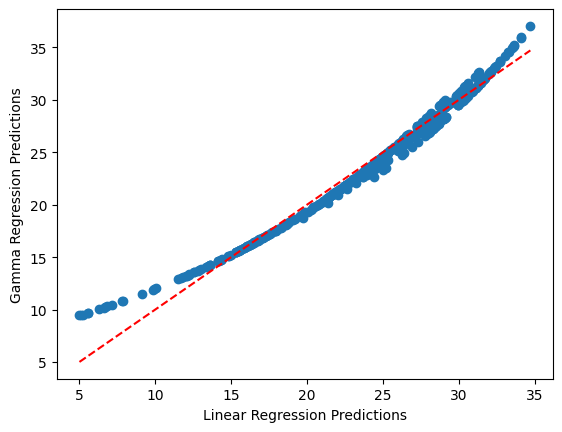

In [12]:
plt.scatter(model_ols.predict(), model_gamma.predict())
plt.xlabel('Linear Regression Predictions')
plt.ylabel('Gamma Regression Predictions')
plt.plot([min(model_ols.predict()), max(model_ols.predict())], [min(model_ols.predict()), max(model_ols.predict())], 'r--')
plt.show()

### How do we interpret the Gamma regression?

The directional interpretation is analogous: A positive coefficient is indicative of an increasing relationship, and vice versa for a negative relationship. Furthermore, we intepret the standard errors, p-values, and confidence intervals as before.

However, for the magnitude we have to incorporate the link-function. The way to think about it with the relationship about the expected value above is:
$$
E[\text{mpg} | \text{acceleration} +1] = E[\text{mpg} | \text{acceleration}] \times e^{-0.0235} =
$$

In [13]:
np.exp(-0.0235)

np.float64(0.9767739746688439)

so, it is reduced by a *factor* of about 2.3% per acceleration unit.

Similarly, going from region A to region B will change mpg by:
$$
E[\text{mpg} | \text{region B}] = E[\text{mpg} | \text{region A} \times e^{-0.0235} =
$$

In [14]:
np.exp(0.0893)

np.float64(1.0934086297167769)

So mpg increases by roughly 9.3%.